# CSCI 532 Semester Project Demonstration and Analysis &mdash; Go Version

James Avery

## Problem #3

>Write a C/C++/Matlab/Java program to compute insertion sort and merge sort. (You can use the code from the textbooks by Deitel and Deitel or from the web.) Obtain the run time of both routines.

>The input data should be an int array containing random element values (between, say, 0 and 1023). Obtain run time T with 1D (input) array of size of $n = 16$, $256$, $4096$, $65536$, $1048576$ (i.e. $2^p$, where $p = 4$, $8$, $12$, $16$, $20$). The run time for each $n$ should be averaged with about $\left\lfloor{\frac{512}{p \times p}}\right\rfloor$ runs. Each run for a given $n$ should use a different random input.

>Plot (with Excel, Matlab, or other available tools) the run time for both routines on one plot, with the $x$ axis in $p$ values, and $y$ axis in $\log{T}$. Label on the plot which curve is for insertion sort and which is for merge sort.

>Submit C/C++ programs and plot, with instructions in readme.txt on how to build and run the program. (Include the Dev-C++/MS Visual Studio/Java NetBeans project file.)

In addition to the above, I also added a number of command line arguments to make testing more interactive:
* `insertion-only`: Prevents merge sort from being run
* `merge-only`: Prevents insertion sort from being run
* `equal-batches`: Instead of running each sort $\left\lfloor\frac{512}{p\times{p}}\right\rfloor$ times, run in equal-sized batches. This takes a lot longer, but allows for more accurate analysis, as well as processing run-time data in Python using NumPy
* `limit-n`: Limits the size of arrays to those that run quickly, i.e., arrays smaller than around 1 million items. This speeds testing the algorithms' run-times, especially when `equal-batches` is also used.
* `demo-sorters`: Demonstrates the sorting routines (specifically that they actually do sort arrays).
* `no-time`: Does not obtain run-times for the sorting algorithms (i.e. does not do what the assignment requires, in order to shorten run-times for `demo-sorters`.)

In initial testing, I noticed that the C++ version, based on Deitel and Deitel's code, was *extremely* slow due to the use of C++11 `std::vector`s rather than C-style arrays. I researched how to parallelize code using C++11's `std::thread` API and the parallel merge sort routine in Cormen et al chapter 27, however the overhead of creating extra threads slowed the program even further and crashed sorting arrays of size $n = 2^{20}$. A better option would be to use `std::async` and futures to serially sort multiple vectors in parallel, but I was not able to grasp that API in time for the project.

I had read before that Google's Go language has native support for concurrency, and after a few hours with the Go tutorials I decided to attempt to reimplement the project in Go. Converting the non-parallelized C++ code was straightforward, and I was able to redo several days' worth of C++ work in a few hours in Go. Go's goroutines and channels make implementing concurrent code reasonably simple. Furthermore, operations on Go's built-in array slice data structure (based on C-style arrays) are much faster than C++ `std::vector`s. Serial `slice`-based Go code runs an order of magnitude faster than `std::vector`-based C++ code, and parallelizing the execution cut serial run-times in half. The simulation below runs in about 45 minutes in Go, but takes around 9 hours in C++ on my computer (Intel i7 8700 with 16 GB of RAM).

## Build the project

The Go language version of the project is built with the command `go build` in a terminal or Windows PowerShell.

In Linux: `go build -o gomain main.go`

In Windows: `go build -o gomain.exe main.go` Note that in Windows, Go is not able to record time with precision lower than 1$\mu$s, so very fast sorts are reported as 0. For this reason, running the program in Linux is *strongly* recommended.

The code cell below checks to see if the executable exists, and builds it if it does not.

In [20]:
import os
import platform

# Determine which operating system we're running under
linux = platform.system() == "Linux"
windows = platform.system() == "Windows"

# Determine if an executable exists
gomain_exists = os.access("gomain", os.F_OK)
gomainexe_exists = os.access("gomain", os.F_OK)

# Determine if the executable is actually executable
gomain_is_executable = os.access("gomain", os.X_OK)
gomainexe_is_executable = os.access("gomain.exe", os.X_OK)

# If the file does not exist or is not executable, then build it
if linux and gomain_is_executable:
    print("Executable exists for Linux.")
elif linux and (not gomain_is_executable or not gomain_exists):
    print("Building for Linux")
    !go build -o gomain main.go
    print("Done.")
elif windows and gomainexe_is_executable:
    print("Executable exists for Windows.")
elif windows and (not gomainexe_is_executable or not gomainexe_exists):
    print("Building for Windows")
    !go build -o gomain.exe main.go
    print("Done.")
else:
    print("Either this is an unsupported OS, or something else is wrong.")

Building for Linux
Done.


## Demonstrate that the sorters sort correctly

Using a combination of the `demo-sorters` and `no-time` command line arguments, it is possible to demonstrate that the insertion sort and merge sort functions do indeed sort arrays into nondecreasing order.

### Insertion Sort

In [2]:
if linux:
    ! ./gomain demo-sorters insertion-only no-time
elif windows:
    ! gomain.exe demo-sorters merge-only no-time


=====  Demonstrating Insertion Sort  =====

Before: [545 527 455 187 385 390 825 684 840 932]
After:  [187 385 390 455 527 545 684 825 840 932]

Before: [198 687 930 1009 344 282 651 149 805 994]
After:  [149 198 282 344 651 687 805 930 994 1009]

Before: [783 218 616 658 127 299 47 248 54 1015]
After:  [47 54 127 218 248 299 616 658 783 1015]

Before: [821 888 475 783 933 332 41 1015 765 914]
After:  [41 332 475 765 783 821 888 914 933 1015]

Before: [653 658 970 835 497 915 990 740 383 89]
After:  [89 383 497 653 658 740 835 915 970 990]

Before: [789 585 501 151 168 529 712 762 871 939]
After:  [151 168 501 529 585 712 762 789 871 939]

Before: [771 30 189 412 362 932 489 130 671 290]
After:  [30 130 189 290 362 412 489 671 771 932]

Before: [587 744 234 758 359 38 457 519 124 180]
After:  [38 124 180 234 359 457 519 587 744 758]

Before: [799 889 257 925 905 43 489 915 515 178]
After:  [43 178 257 489 515 799 889 905 915 925]

Before: [958 88 898 499 548 263 344 163 397 382]
After

### Merge Sort

In [3]:
if linux:
    ! ./gomain demo-sorters merge-only no-time
elif windows:
    ! gomain.exe demo-sorters merge-only no-time


=====  Demonstrating Merge Sort  =====

Before: [545 527 455 187 385 390 825 684 840 932]
After:  [187 385 390 455 527 545 684 825 840 932]

Before: [198 687 930 1009 344 282 651 149 805 994]
After:  [149 198 282 344 651 687 805 930 994 1009]

Before: [783 218 616 658 127 299 47 248 54 1015]
After:  [47 54 127 218 248 299 616 658 783 1015]

Before: [821 888 475 783 933 332 41 1015 765 914]
After:  [41 332 475 765 783 821 888 914 933 1015]

Before: [653 658 970 835 497 915 990 740 383 89]
After:  [89 383 497 653 658 740 835 915 970 990]

Before: [789 585 501 151 168 529 712 762 871 939]
After:  [151 168 501 529 585 712 762 789 871 939]

Before: [771 30 189 412 362 932 489 130 671 290]
After:  [30 130 189 290 362 412 489 671 771 932]

Before: [587 744 234 758 359 38 457 519 124 180]
After:  [38 124 180 234 359 457 519 587 744 758]

Before: [799 889 257 925 905 43 489 915 515 178]
After:  [43 178 257 489 515 799 889 905 915 925]

Before: [958 88 898 499 548 263 344 163 397 382]
After:  [

## Find Run-Times

This is the main part of project as assigned, with one difference: for the analysis portion with Go I will run the sorters with the `equal-batches` flag. The total run time to sort 24 vectors of 5 sizes using both algorithms is around 45 minutes on a fast computer.

### Insertion Sort

In [4]:
if linux:
    !./gomain insertion-only equal-batches
elif windows:
    ! gomain.exe insertion-only equal-batches


 Insertion Sort

16:	1686 1582 1207 1146 1015 1073 1143 898 1357 1337 1182 982 849 1068 1389 1236 724 1171 1270 999 916 1124 1396 1181 

256:	51843 64857 70407 56515 99977 107206 118514 94816 61941 110186 68559 82899 76665 63522 97666 54791 62013 62159 102952 55447 57003 78656 94081 60601 

4096:	11418666 13861437 14468685 15428230 15486188 15438344 15195752 15843800 15166712 14924065 9722887 17079095 10931245 9687711 9573470 8198074 9210489 9596277 8630520 9203230 8741297 12369262 7480015 4986462 

65536:	944504333 947986830 946264717 943051753 1000777037 998540395 1003005837 996209764 993944368 1380961473 1382529531 1385917437 1387515670 1384121654 1379362710 1361424986 1366166582 1369384561 1367823842 1363078871 1370967107 1364620109 898237680 917904773 

1048576:	228852509901 230545666372 242950970898 242977851558 239265620418 239291677805 264745621343 264800396597 264771164289 314955679707 314929749758 314981039848 315008050691 405443316849 405469122051 405392179816 405417888820 

### Merge Sort

In [5]:
if linux:
    !./gomain merge-only equal-batches
elif windows:
    ! gomain.exe merge-only equal-batches


 Merge Sort

16:	1446 1216 1169 1108 1074 1203 1114 6239 1084 1011 1278 1099 1225 1079 12038 1274 1089 1204 1135 1121 2038 1072 13053 8388 

256:	35989 52226 55283 48114 43578 35112 39543 93139 38165 37318 38701 37240 36810 67623 37454 37043 40618 57893 37193 29721 64989 47829 57444 57771 

4096:	597220 812523 573664 626165 1976099 2413183 2347512 2768977 2908726 1605743 3090222 3071282 3070550 1107349 1350401 1283794 1236951 1154511 1360911 527070 602122 778044 548086 895322 

65536:	14143821 14490763 16181056 15723287 14387238 13821691 15527861 15168650 14375954 15607430 14972163 15638992 16677569 18454764 16959266 15130115 14814497 16599703 15450932 13421121 12899375 12805103 13638507 12201965 

1048576:	181538844 206636089 205349016 212508486 205676507 219840945 213658406 215107279 200278224 213347379 213968957 218699600 208881571 205115908 208187612 196549673 203844384 204098676 216906895 208822412 200562246 194872104 182479074 185654210 


## Prepare the data for processing

Load the run-times into Pandas dataframes for processing.

In [6]:
import numpy as np
import pandas as pd
import IPython as ipy

insertion = pd.read_table('insertionsort.csv', 
                          sep=',', header=None, index_col=0)
merge = pd.read_table('mergesort.csv', 
                      sep=',', header=None, index_col=0)

#### Insertion Sort Run Times

In [16]:
ipy.display.display(
    ipy.display.HTML(
        insertion.to_html(na_rep='', max_cols=8, header=False)))

16,1582,1146,1073,898,...,1171,999,1124,1181
256,64857,56515,107206,94816,...,62159,55447,78656,60601
4096,13861437,15428230,15438344,15843800,...,9596277,9203230,12369262,4986462
65536,947986830,943051753,998540395,996209764,...,1369384561,1363078871,1364620109,917904773
1048576,230545666372,242977851558,239291677805,264800396597,...,405495195535,394010406796,393926741390,221855489191


#### Merge Sort Run Times

In [15]:
ipy.display.display(
    ipy.display.HTML(
        merge.to_html(na_rep='', max_cols=10, header=False)))

16,1216,1108,1203,6239,1011,...,12038,1204,1121,1072,8388
256,52226,48114,35112,93139,37318,...,37043,57893,29721,47829,57771
4096,812523,626165,2413183,2768977,1605743,...,1283794,1154511,527070,778044,895322
65536,14490763,15723287,13821691,15168650,15607430,...,15130115,16599703,13421121,12805103,12201965
1048576,206636089,212508486,219840945,215107279,213347379,...,196549673,204098676,208822412,194872104,185654210


Calculate the mean of each row, discarding missing columns.

In [9]:
insertion_mean = insertion.mean(axis=1).as_matrix()
merge_mean = merge.mean(axis=1).as_matrix()

The data is stored in rows of the format $n, r_1, r_2, \ldots r_i$, where $n$ is the size of the array, and $r_i$ is the run-time in nanoseconds of the $i^{\textrm{th}}$ run, so extract the first row as $x$ values for the graph.

In [10]:
insertion_xs = insertion.index.tolist()
merge_xs = merge.index.tolist()

if insertion_xs != merge_xs:
    raise ValueError(
        "The two data sets were not tested on arrays of the same sizes." +
            "\n\tInsertion Sort was tested with arrays of sizes:\n\t\t" +
            str(insertion_xs) +
           "\n\tMerge Sort was tested with arrays of sizes:\n\t\t" +
            str(merge_xs))
else:
    xs = np.array(insertion_xs.copy())
    del insertion_xs, merge_xs

## Graph the results

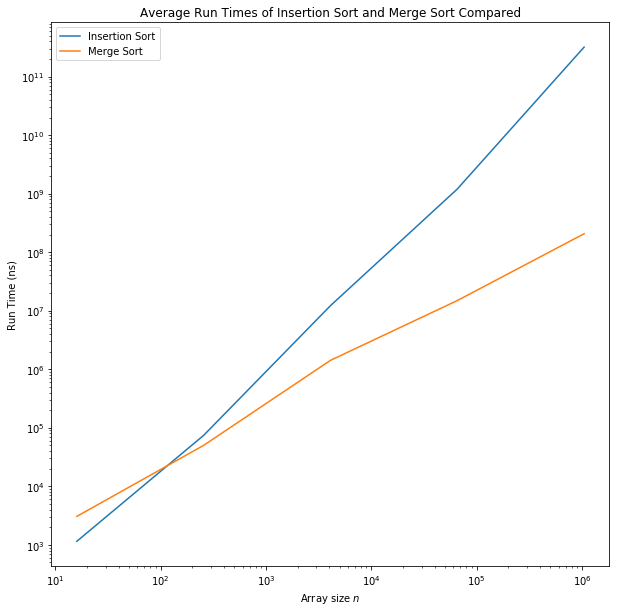

In [18]:
import matplotlib.pyplot as plt
import IPython

plt.rcParams['figure.figsize'] = [10, 10]
plt.plot(xs, insertion_mean, label='Insertion Sort')
plt.plot(xs, merge_mean, label='Merge Sort')
plt.legend()
plt.xscale('log')
plt.yscale('log')
plt.xlabel("Array size $n$")
plt.ylabel('Run Time (ns)')
plt.title("Average Run Times of Insertion Sort and Merge Sort Compared")
plt.show()

In [11]:
table = "| $n$ | Insertion Sort | Merge Sort |\n|:---|:---:|:---:|\n"
for i in range(len(xs)):
    table += "| {n} | {ins:.5} | {ms:.5} |\n".format(
        n=xs[i], 
        ins=insertion_mean[i], 
        ms=merge_mean[i]
    )
IPython.display.Markdown(table)

| $n$ | Insertion Sort | Merge Sort |
|:---|:---:|:---:|
| 16 | 1149.8 | 3064.8 |
| 256 | 7.4305e+04 | 5.0086e+04 |
| 4096 | 1.2218e+07 | 1.4203e+06 |
| 65536 | 1.2014e+09 | 1.4922e+07 |
| 1048576 | 3.1947e+11 | 2.0677e+08 |


## Notebook Cleanup/Additional Information

### This document was created with the following software versions:

In [12]:
pd.show_versions()


INSTALLED VERSIONS
------------------
commit: None
python: 3.6.4.final.0
python-bits: 64
OS: Linux
OS-release: 4.13.0-38-lowlatency
machine: x86_64
processor: x86_64
byteorder: little
LC_ALL: None
LANG: en_US.UTF-8
LOCALE: en_US.UTF-8

pandas: 0.22.0
pytest: 3.3.2
pip: 9.0.1
setuptools: 38.4.0
Cython: 0.27.3
numpy: 1.14.0
scipy: 1.0.0
pyarrow: None
xarray: None
IPython: 6.2.1
sphinx: 1.6.6
patsy: 0.5.0
dateutil: 2.6.1
pytz: 2017.3
blosc: None
bottleneck: 1.2.1
tables: 3.4.2
numexpr: 2.6.4
feather: None
matplotlib: 2.1.2
openpyxl: 2.4.10
xlrd: 1.1.0
xlwt: 1.3.0
xlsxwriter: 1.0.2
lxml: 4.1.1
bs4: 4.6.0
html5lib: 0.9999999
sqlalchemy: 1.2.1
pymysql: None
psycopg2: None
jinja2: 2.10
s3fs: None
fastparquet: None
pandas_gbq: None
pandas_datareader: None


In [21]:
%%javascript
// Hide "In [*]" prompts in notebook.
$('div.prompt').hide();

<IPython.core.display.Javascript object>